# PNG to GeoTIFF Conversion Pipeline

## Summary

In this chapter we build a workflow for converting our image data to geotiff files usable by geosam.\
TODO: elaborate

In [1]:
import numpy as np
import os.path
import scipy.io
from PIL import Image as im
import matplotlib.pyplot as plt
import pyproj

In [2]:
# We only use this running locally, since this data file is too big for Github.
airborne_data_path = "../data/AirborneData.mat"
# If you are running on colab, use this instead:
# airborne_data_path = "elwha_dataset_realignment/book/data/AirborneDataMini.mat"
# For just using the mini dataset locally:
# airborne_data_path = "../data/AirborneDataMini.mat"

assert os.path.exists(airborne_data_path)

Loading the massive `mat` file takes a while so we place it in its own code cell.

In [3]:
airborne_data = scipy.io.loadmat(airborne_data_path)

Let's take a look at the keys.

In [4]:
airborne_keys = list(airborne_data.keys())
print(airborne_keys)

['__header__', '__version__', '__globals__', 'imageRGB', 'imageIR', 'maskRiver', 'tempRiver', 'northings', 'eastings', 'Xt', 'Yt', 'Zt', 'altitude', 'datePDT']


In [5]:
class color:
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    END = "\033[0m"

def peekAtData(index: int):
    key = airborne_keys[index]
    data = airborne_data[key]

    print(color.BOLD + ">", key + color.END)
    print(type(data))
    print(data.shape, "\n")

    return data

In [6]:
northings_data = peekAtData(7)
eastings_data = peekAtData(8)

> northings
<class 'numpy.ndarray'>
(406, 1) 

> eastings
<class 'numpy.ndarray'>
(406, 1) 



> Xt
<class 'numpy.ndarray'>
(480, 640, 406) 

> Yt
<class 'numpy.ndarray'>
(480, 640, 406) 



(-0.5, 479.5, 639.5, -0.5)

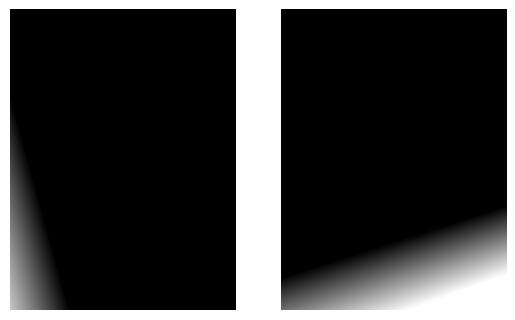

In [7]:
xt_data = peekAtData(9)
yt_data = peekAtData(10)
# zt_data = peekAtData(11)

show_index = 10
xt_image_data = im.fromarray(np.rot90(xt_data[:,:,show_index], -1, (0, 1)))
yt_image_data = im.fromarray(np.rot90(yt_data[:,:,show_index], -1, (0, 1)))
# zt_image_data = im.fromarray(np.rot90(zt_data[:,show_index], -1, (0, 1)))

figure, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(xt_image_data)
ax1.imshow(yt_image_data)
# ax2.imshow(zt_image_data)
ax0.axis("off")
ax1.axis("off")
# ax2.axis("off")

In [8]:
rgb_data = peekAtData(3)
ir_data = peekAtData(4)

> imageRGB
<class 'numpy.ndarray'>
(640, 480, 406, 3) 

> imageIR
<class 'numpy.ndarray'>
(480, 640, 406) 



In [9]:
date_data = peekAtData(13)
date_data[0]

> datePDT
<class 'numpy.ndarray'>
(406,) 



'08-Sep-2012 12:53:57'

In [10]:
def convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere=True):
    """
    Convert UTM coordinates (easting, northing) to latitude and longitude.

    Args:
        easting (float): Easting coordinate in meters.
        northing (float): Northing coordinate in meters.
        zone_number (int): UTM zone number (e.g., 33 for UTM Zone 33N).
        northern_hemisphere (bool): True for northern hemisphere, False for southern.

    Returns:
        (float, float): Latitude and Longitude in decimal degrees.
    """
    # Define the UTM projection based on the given zone number and hemisphere
    utm_crs = f"+proj=utm +zone={zone_number} {'+north' if northern_hemisphere else '+south'} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    
    # Create a transformer from UTM to WGS84 (latitude and longitude)
    transformer = pyproj.Transformer.from_crs(utm_crs, "+proj=longlat +datum=WGS84", always_xy=True)
    
    # Perform the transformation
    lon, lat = transformer.transform(easting, northing)

    return lat, lon

In [11]:
# Example usage, testing Seattle
easting = 549967.97
northing = 5272948.10
zone_number = 10 # UTM zone for west coast is 10
northern_hemisphere = True

latitude, longitude = convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere)
print(f"Latitude: {latitude}, Longitude: {longitude}")

Latitude: 47.60801296515217, Longitude: -122.33516697208582


In [12]:
from osgeo import gdal
from osgeo import osr

<class 'numpy.ndarray'> (640, 480, 3)


(-0.5, 479.5, 639.5, -0.5)

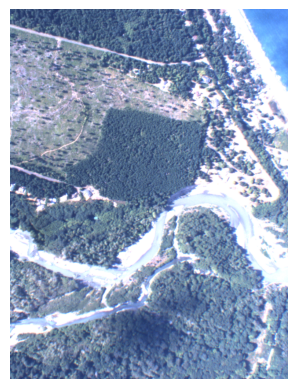

In [13]:
image_index = 0
image = rgb_data[:,:,image_index]
image_size = image.shape[:2]

print(type(image), image.shape)
plt.imshow(image)
plt.axis("off")

In [14]:
#  Setting the geographic transform

easting = eastings_data[image_index]
northing = northings_data[image_index]
zone_number = 10 # UTM zone for west coast is 10
northern_hemisphere = True

lat_center, lon_center = convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere)
print(f"Latitude: {lat_center}, Longitude: {lon_center}") # If we test on https://www.gps-coordinates.net/ these values are accurate

lat = [48.141964,48.132469]
lon = [-123.573719,-123.551918]

Latitude: [48.13767712], Longitude: [-123.56505045]


In [78]:
# create each channel
r_pixels = image[:,:,0]
g_pixels = image[:,:,1]
b_pixels = image[:,:,2]

# set geotransform
nx = image_size[0]
ny = image_size[1]
xmin, ymin, xmax, ymax = [min(lon), min(lat), max(lon), max(lat)]
xres = (xmax - xmin) / float(nx)
yres = (ymax - ymin) / float(ny)
geotransform = (xmin, xres, 0, ymax, 0, -yres)

In [75]:
# create the 3-band raster file
tif_image = "myGeoTIFF.tif"
dst_ds = gdal.GetDriverByName("GTiff").Create(tif_image, ny, nx, 3, gdal.GDT_Byte)

dst_ds.SetGeoTransform(geotransform)    # specify coords
srs = osr.SpatialReference()            # establish encoding
srs.ImportFromEPSG(3857)                # WGS84 lat/long
dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(r_pixels)   # write r-band to the raster
dst_ds.GetRasterBand(2).WriteArray(g_pixels)   # write g-band to the raster
dst_ds.GetRasterBand(3).WriteArray(b_pixels)   # write b-band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

BoundingBox(left=-123.573719, bottom=48.129304, right=-123.55736825, top=48.141964) EPSG:3857


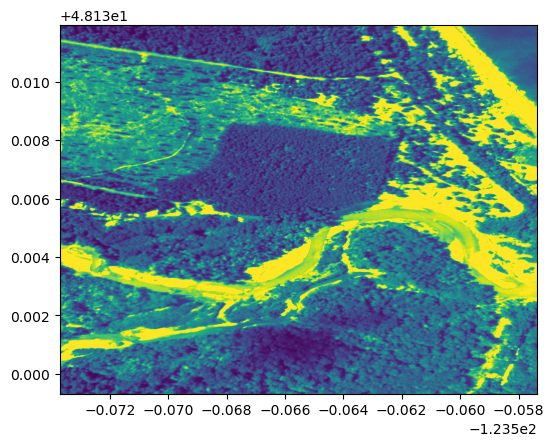

In [81]:
import rasterio
from rasterio.plot import show

with rasterio.open(tif_image) as ds:
 print(ds.bounds, ds.crs)
 show(ds.read(1), transform=ds.profile["transform"])

In [45]:
from samgeo import SamGeo, tms_to_geotiff
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: C:\Users\stefa\.cache\torch\hub\checkpoints\sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [03:27<00:00, 12.3MB/s]


In [48]:
sam.set_image(tif_image)

In [84]:
prediction_mask = "mask1.tif"
# sam.predict(output=prediction_mask)

point_coords = [[48.135964, -123.561918]]
sam.predict(point_coords, point_labels=1, point_crs="EPSG:3857", output=prediction_mask)

No valid pixel coordinates found.


IndexError: index 0 is out of bounds for axis 0 with size 0

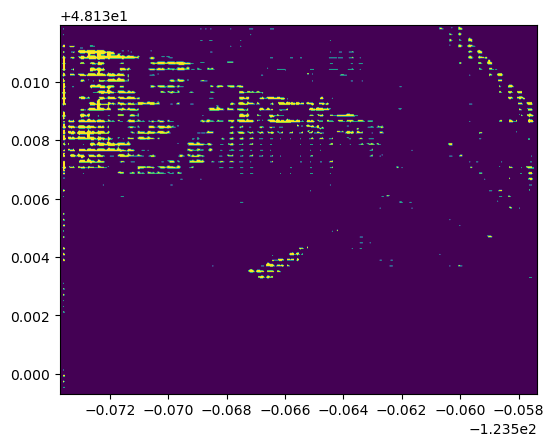

In [57]:
with rasterio.open(prediction_mask) as ds:
 show(ds.read(1), transform=ds.profile['transform'])